In [1]:
!pip install datasets --upgrade

In [2]:
from datasets import load_dataset
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch
import random
from tqdm import tqdm
from collections import Counter
from torch.utils.data import random_split
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import wandb
from torchsummary import summary
import numpy as np
import torch.nn.functional as F
from sklearn.metrics import classification_report

c:\Users\Emery\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
dataset = load_dataset("garythung/trashnet",split = 'train')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [4]:
print(dataset)

Dataset({
    features: ['image', 'label'],
    num_rows: 5054
})


In [5]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


set_seed(42)

# Exploratory Image Analysis

Check sizes from random images sample in pytorch format

In [6]:
def check_random_image_sizes(dataset, num_samples=10):
    for _ in range(num_samples):
        idx = random.randint(0, len(dataset) - 1)
        img = dataset[idx]['image']
        print(f"Image {idx}: size={img.shape}")


In [7]:
dst = dataset.with_format('torch')
check_random_image_sizes(dst)

Image 912: size=torch.Size([3, 3024, 4032])
Image 204: size=torch.Size([3, 3024, 4032])
Image 2253: size=torch.Size([3, 4032, 3024])
Image 2006: size=torch.Size([3, 3264, 2448])
Image 1828: size=torch.Size([3, 3024, 4032])
Image 1143: size=torch.Size([3, 4032, 3024])
Image 839: size=torch.Size([3, 4032, 3024])
Image 4467: size=torch.Size([3, 384, 512])
Image 712: size=torch.Size([3, 4032, 3024])
Image 4837: size=torch.Size([3, 384, 512])


We can see that the Images has various size, so we need to do transform resize them later before we fit into our model

## Visualize the random image sample from dataset

In [8]:
print(dataset[403]['label'])

1


In [9]:
classes_sample = {
    'cardboard': [5,6,7,8,9],
    'glass': [403,404,405,406,420],
    'metal': [910,911,915,921,925],
    'paper': [1315,1319,1323,1327,1331],
    'plastic': [1911,1939,1945,1956,1970],
    'trash': [2392,2399,2390,2400,2451]
}

In [10]:
def show_sample_images(dataset, classes_sample):
    for label, indices in classes_sample.items():
        num_samples = len(indices)

        plt.figure(figsize=(12, 4))
        plt.suptitle(f"Samples for Label: {label}", fontsize=16)

        for i, idx in enumerate(indices):
            plt.subplot(1, num_samples, i + 1)
            img = dataset[idx]['image']
            plt.imshow(img)
            plt.title(f"Label: {label}")
            plt.axis('off')

        plt.tight_layout()
        plt.show()


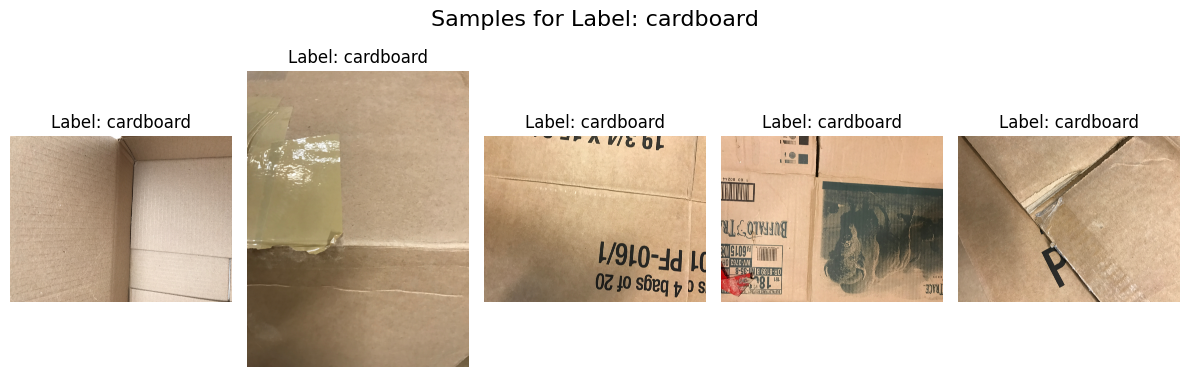

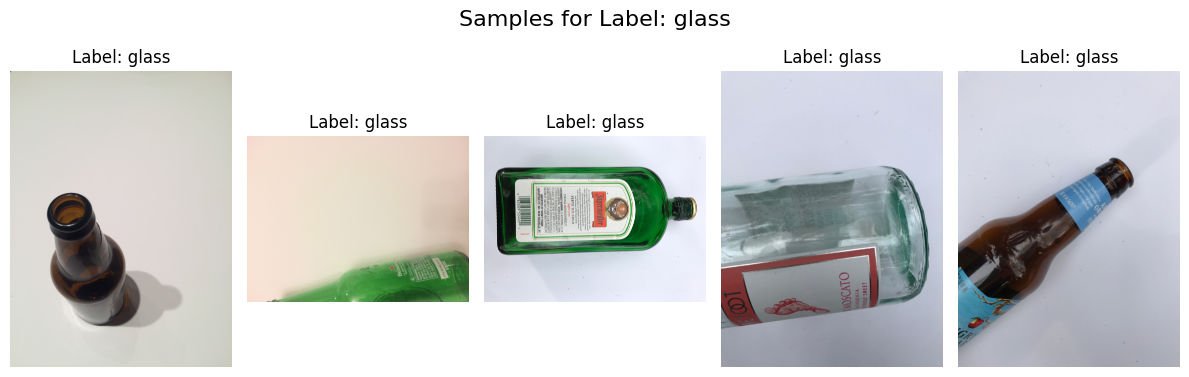

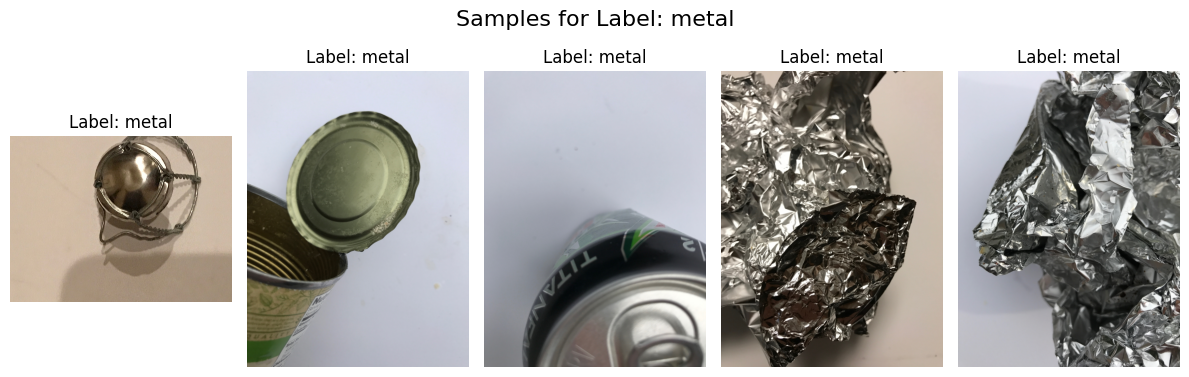

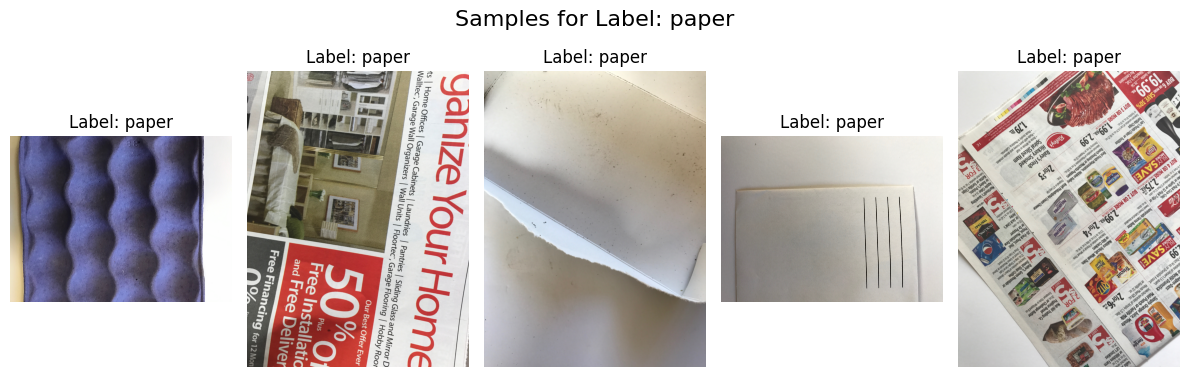

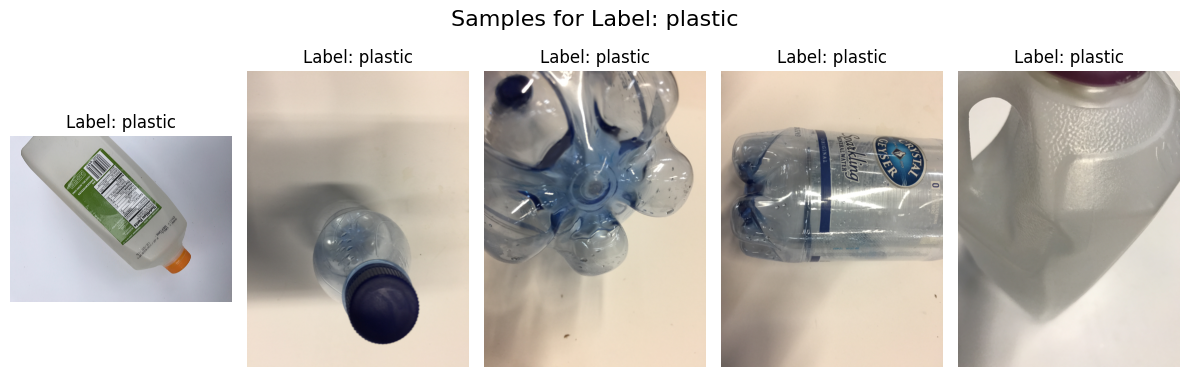

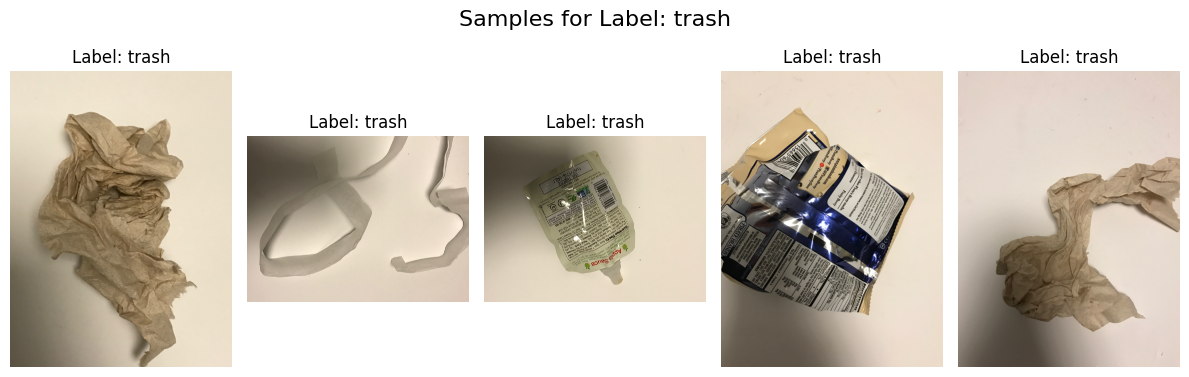

In [11]:
show_sample_images(dataset,classes_sample)

## Labels Distribution

In [12]:
def show_distribution(dataset):

    plt.figure(figsize=(10, 6))
    sns.countplot(x=dataset['label'], palette='viridis')
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.title('Distribution of Labels')
    plt.show()


<ipython-input-12-5e03dba1daf0>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=dataset['label'], palette='viridis')


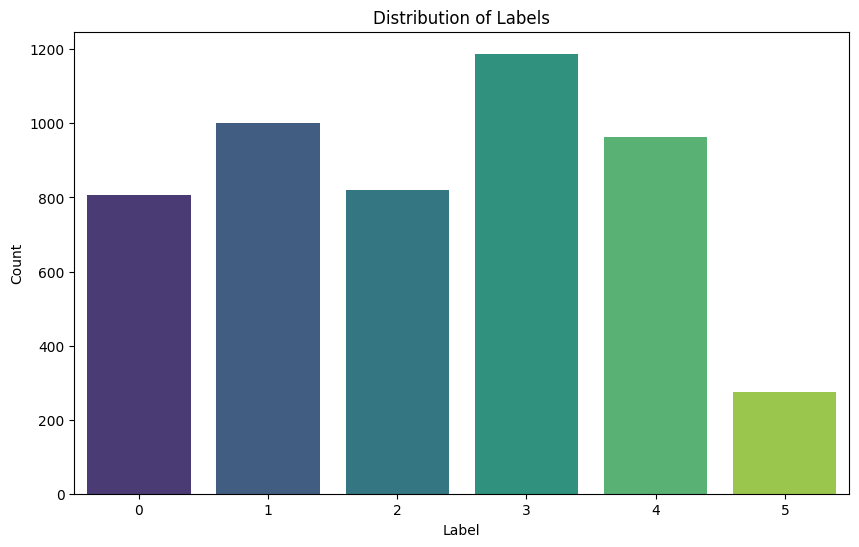

In [13]:
show_distribution(dataset)

We can see that trash is minority class

# Data Preparation

1. From the past EIA we got that the images size is various so we need to resize it so we can fit into the our model later
2. In pytorch we need to transform the image into tensor format so we can fit it into the model
3. We better normalize the feature in the image so it has same scale. it can help to faster convergance too
4. I think we don't need data augmentation due to for the computational resources i have 5000 dataset is enough.

In [14]:
class HFDatasetWrapper(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.hf_dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        image = self.hf_dataset[idx]['image']
        label = self.hf_dataset[idx]['label']

        if self.transform:
            image = self.transform(image)

        return image, label

In [15]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

We use the common mean and std due to i tried to calculated the mean and std in our dataset but it takes to long so i decided to use common value.

In [16]:
tensor_dataset = HFDatasetWrapper(dataset,transform)

Split the dataset

In [17]:
train_size = int(0.75 * len(tensor_dataset))
val_size = int(0.15*len(tensor_dataset))
test_size = len(tensor_dataset) - train_size - val_size
train_dataset, val_dataset,test_dataset = random_split(tensor_dataset, [train_size, val_size, test_size])

In [71]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True,num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=True,num_workers =0)
test_loader =DataLoader(test_dataset, batch_size = 128,shuffle = True,num_workers = 0)

## Visualize after Transformation

Just to see and make sure our transformations are done correctly

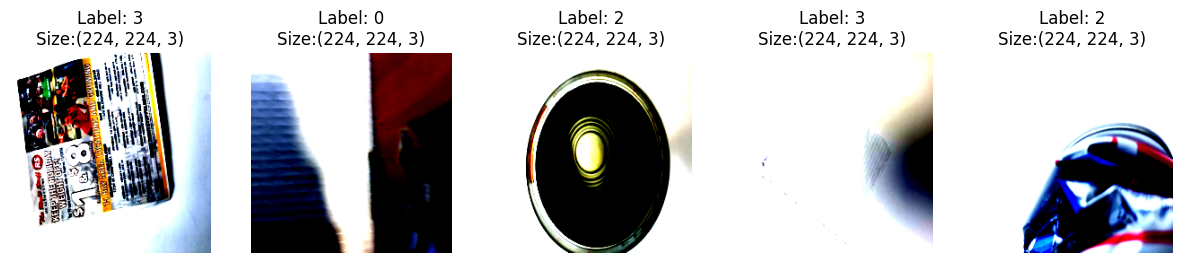

In [19]:
import random
import matplotlib.pyplot as plt

def show_image_after_transform(dataset, num_samples=5):
    plt.figure(figsize=(15,5))
    for i in range(num_samples):
        plt.subplot(1,num_samples, i+1)
        idx = random.randint(0, len(dataset) - 1)
        image_tensor, label = dataset[idx]
        image_np = image_tensor.permute(1, 2, 0).numpy()
        plt.imshow(image_np)
        plt.title(f"Label: {label}\nSize:{image_np.shape}")
        plt.axis("off")
    plt.show()
show_image_after_transform(train_dataset)

# Model

## Create the CNN Architecture

In [3]:
class MiniVGG_BN(nn.Module):
    def __init__(self, num_classes=6):

        super(MiniVGG_BN, self).__init__()

        # Block 1
        self.conv1_1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1_1   = nn.BatchNorm2d(16)

        self.conv1_2 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.bn1_2   = nn.BatchNorm2d(16)

        # Block 2
        self.conv2_1 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2_1   = nn.BatchNorm2d(32)


        # Block 3
        self.conv3_1 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3_1   = nn.BatchNorm2d(64)

        # Block 4
        self.conv4_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn4_1   = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(128 * 14 * 14, 256)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self,x):
        # Block 1
        x = F.relu(self.bn1_1(self.conv1_1(x)))
        x = F.relu(self.bn1_2(self.conv1_2(x)))
        x = self.pool(x)

        # Block 2
        x = F.relu(self.bn2_1(self.conv2_1(x)))
        x = self.pool(x)

        # Block 3
        x = F.relu(self.bn3_1(self.conv3_1(x)))
        x = self.pool(x)
        # Block 4
        x = F.relu(self.bn4_1(self.conv4_1(x)))
        x = self.pool(x)
        x = nn.Flatten()(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x




## Architecture Explanation
1. I used 4 block of conv,batchnorm, and maxpool layer
2. I used batchnorm to prevent internal covariate shift and   faster convergance, and maxpool to downsample the h and w.
3. the first block i used 2 conv just inspired by vgg. why i dont go deeper is due to prevent overfitting(although in can be prevent by use Residual block but i lack of time and computational resources).
4. I used dropout to prevent overfitting because from my experiment i get that train accuracy and loss is still going higher and lower after certain epoch and the val acc and loss is lower and higher, so it kind of overfitt.
5. As you can see below the model has 6.5M parameters.

In [4]:
num_classes = 6
model = MiniVGG_BN(num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [5]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
       BatchNorm2d-2         [-1, 16, 224, 224]              32
            Conv2d-3         [-1, 16, 224, 224]           2,320
       BatchNorm2d-4         [-1, 16, 224, 224]              32
         MaxPool2d-5         [-1, 16, 112, 112]               0
            Conv2d-6         [-1, 32, 112, 112]           4,640
       BatchNorm2d-7         [-1, 32, 112, 112]              64
         MaxPool2d-8           [-1, 32, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          18,496
      BatchNorm2d-10           [-1, 64, 56, 56]             128
        MaxPool2d-11           [-1, 64, 28, 28]               0
           Conv2d-12          [-1, 128, 28, 28]          73,856
      BatchNorm2d-13          [-1, 128, 28, 28]             256
        MaxPool2d-14          [-1, 128,

Our model just has 6M parameters which is light enough for computational I have.

## login wandb

In [23]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: emeryzwageri (emeryzwageri-institut-teknologi-bandung). Use `wandb login --relogin` to force relogin


True

In [24]:
wandb.init(project = "Trash-Classification",
           resume = 'never',
           config = {
               "epochs" : 25,
               "batch_size" :128,
               "learning_rate" : 0.001,
               "architecture" : "CNN",
               "num_classes" : 6
           })

In [25]:
def evaluate_model(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)

            _, preds = torch.max(outputs, dim=1)
            total_correct += (preds == labels).sum().item()
            total_samples += labels.size(0)

    avg_loss = running_loss / total_samples
    accuracy = total_correct / total_samples

    return avg_loss, accuracy

In [26]:
def train_model(model, train_loader, val_loader, optimizer, criterion, epochs, patience):
  model.train()
  best_val_loss = float('inf')
  epochs_no_improve = 0
  for epoch in range(epochs):
    train_loader_tqdm = tqdm(train_loader, desc="Training", leave=True)

    running_loss = 0.0
    total_samples = 0
    total_correct = 0

    for inputs, labels in train_loader_tqdm:
      # Set tensor to device
      inputs, labels = inputs.to(device), labels.to(device)
      optimizer.zero_grad() # Make sure gradient is set to zero
      # Forward pass
      outputs = model(inputs)
      _, preds  = torch.max(outputs, dim=1)
      loss = criterion(outputs, labels)#Calculate loss
      # Backward pass
      loss.backward()
      optimizer.step()
      # Calculate running loss and accuracy
      total_correct += (preds == labels).sum().item()
      running_loss += loss.item()*inputs.size(0)
      total_samples +=inputs.size(0)
      train_loader_tqdm.set_postfix(loss=running_loss/total_samples)
    # Calculate avg training loss for this epoch
    avg_train_loss = running_loss / total_samples
    train_acc = total_correct*100/total_samples
    # Calculate Val Loss for this epoch
    val_loss, val_acc = evaluate_model(model, val_loader, criterion, device)
    # Display training loss for this epoch and log to wandb
    wandb.log({"epoch":epoch+1 ,"train_loss": avg_train_loss, "train_acc": train_acc, "val_loss": val_loss, "val_acc": val_acc})

    print(f"Epoch {epoch+1}/{epochs},Train Loss: {avg_train_loss:.4f} | Train Acc:{train_acc:.2f}% | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    if val_loss < best_val_loss:
      best_val_loss = val_loss
      epochs_no_improve = 0
      # Save the best model
      torch.save(model.state_dict(), "best_model.pth")
    else:
      epochs_no_improve +=1
      print(f"No improvement in validation loss. Patience counter: {epochs_no_improve}/{patience}")

    if epochs_no_improve >= patience:
      print("Early stopping triggered")
      break




Train the model

In [27]:
train_model(model, train_loader,val_loader,  optimizer,criterion,epochs = 25, patience = 3)

Training: 100%|██████████| 30/30 [02:45<00:00,  5.51s/it, loss=3.77]


Epoch 1/25,Train Loss: 3.7655 | Train Acc:36.46% | Val Loss: 1.4265 | Val Acc: 0.4657


Training: 100%|██████████| 30/30 [02:45<00:00,  5.53s/it, loss=1.21]


Epoch 2/25,Train Loss: 1.2052 | Train Acc:54.49% | Val Loss: 1.1587 | Val Acc: 0.5554


Training: 100%|██████████| 30/30 [02:43<00:00,  5.45s/it, loss=1.01]


Epoch 3/25,Train Loss: 1.0139 | Train Acc:62.88% | Val Loss: 1.0581 | Val Acc: 0.6042


Training: 100%|██████████| 30/30 [02:45<00:00,  5.53s/it, loss=0.894]


Epoch 4/25,Train Loss: 0.8944 | Train Acc:67.52% | Val Loss: 0.9866 | Val Acc: 0.6227


Training: 100%|██████████| 30/30 [02:43<00:00,  5.45s/it, loss=0.792]


Epoch 5/25,Train Loss: 0.7919 | Train Acc:71.61% | Val Loss: 1.0111 | Val Acc: 0.6346
No improvement in validation loss. Patience counter: 1/3


Training: 100%|██████████| 30/30 [02:44<00:00,  5.48s/it, loss=0.765]


Epoch 6/25,Train Loss: 0.7650 | Train Acc:70.84% | Val Loss: 0.9344 | Val Acc: 0.6807


Training: 100%|██████████| 30/30 [02:49<00:00,  5.64s/it, loss=0.631]


Epoch 7/25,Train Loss: 0.6312 | Train Acc:77.23% | Val Loss: 0.9809 | Val Acc: 0.6741
No improvement in validation loss. Patience counter: 1/3


Training: 100%|██████████| 30/30 [02:45<00:00,  5.52s/it, loss=0.552]


Epoch 8/25,Train Loss: 0.5524 | Train Acc:80.08% | Val Loss: 0.9170 | Val Acc: 0.6992


Training: 100%|██████████| 30/30 [02:44<00:00,  5.48s/it, loss=0.468]


Epoch 9/25,Train Loss: 0.4681 | Train Acc:82.96% | Val Loss: 0.9201 | Val Acc: 0.7018
No improvement in validation loss. Patience counter: 1/3


Training: 100%|██████████| 30/30 [02:43<00:00,  5.46s/it, loss=0.4]


Epoch 10/25,Train Loss: 0.3997 | Train Acc:85.80% | Val Loss: 0.9162 | Val Acc: 0.7124


Training: 100%|██████████| 30/30 [02:47<00:00,  5.58s/it, loss=0.357]


Epoch 11/25,Train Loss: 0.3568 | Train Acc:87.55% | Val Loss: 0.9469 | Val Acc: 0.7124
No improvement in validation loss. Patience counter: 1/3


Training: 100%|██████████| 30/30 [02:47<00:00,  5.58s/it, loss=0.305]


Epoch 12/25,Train Loss: 0.3046 | Train Acc:89.00% | Val Loss: 1.0483 | Val Acc: 0.6926
No improvement in validation loss. Patience counter: 2/3


Training: 100%|██████████| 30/30 [02:42<00:00,  5.41s/it, loss=0.247]


Epoch 13/25,Train Loss: 0.2467 | Train Acc:91.72% | Val Loss: 1.1651 | Val Acc: 0.7084
No improvement in validation loss. Patience counter: 3/3
Early stopping triggered


In [28]:
wandb.finish()


# Eval and Test the Model

In [34]:
def final_eval(model, test_loader, criterion, device, best_model_path):
    # Load the best model weights
    model.load_state_dict(torch.load(best_model_path, weights_only=True))
    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(test_loader):
            # Move inputs and labels to the correct device
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, dim=1)  # Get the predicted class

            # Accumulate loss and accuracy
            total_loss += loss.item() * inputs.size(0)
            total_correct += (preds == labels).sum().item()
            total_samples += labels.size(0)

            # Collect all predictions and labels for detailed analysis
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate overall loss and accuracy
    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples

    print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.4f}")

    return avg_loss, accuracy, all_preds, all_labels





In [41]:
avg_loss, accuracy, all_preds, all_labels = final_eval(
    model=model,
    test_loader=test_loader,
    criterion=torch.nn.CrossEntropyLoss(),
    device="cuda",
    best_model_path="/content/best_model_6.5M0,2.pth"
)




Test Loss: 0.8005, Test Accuracy: 0.7253
[[70  2  4  2  4  1]
 [ 2 75  6  5  8  3]
 [ 4 12 38  6  4  6]
 [ 6  3  5 99  5  2]
 [ 5 15  5  5 68  2]
 [ 2  7  0  6  2 17]]
              precision    recall  f1-score   support

           0       0.79      0.84      0.81        83
           1       0.66      0.76      0.70        99
           2       0.66      0.54      0.59        70
           3       0.80      0.82      0.81       120
           4       0.75      0.68      0.71       100
           5       0.55      0.50      0.52        34

    accuracy                           0.73       506
   macro avg       0.70      0.69      0.69       506
weighted avg       0.72      0.73      0.72       506



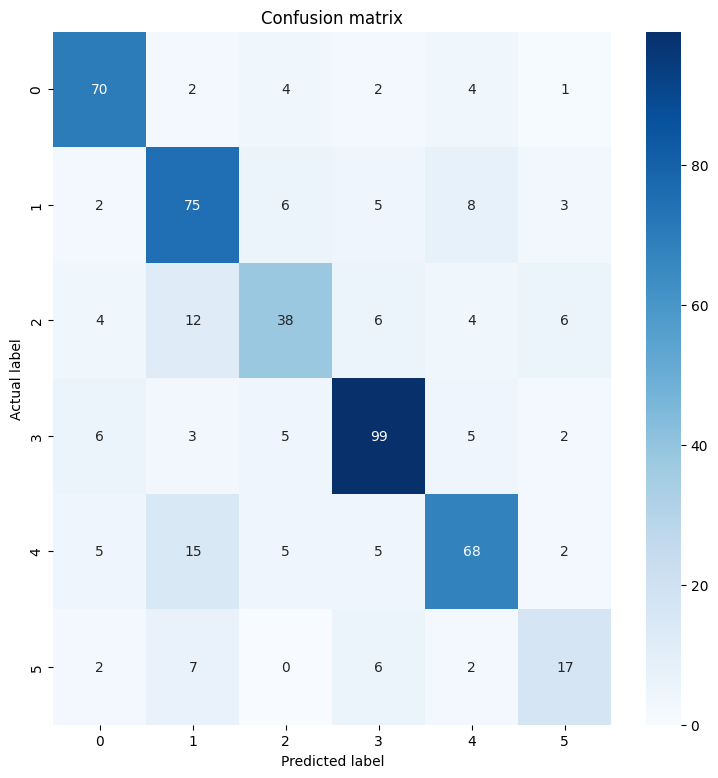

              precision    recall  f1-score   support

           0       0.79      0.84      0.81        83
           1       0.66      0.76      0.70        99
           2       0.66      0.54      0.59        70
           3       0.80      0.82      0.81       120
           4       0.75      0.68      0.71       100
           5       0.55      0.50      0.52        34

    accuracy                           0.73       506
   macro avg       0.70      0.69      0.69       506
weighted avg       0.72      0.73      0.72       506



In [44]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize = (9,9))
sns.heatmap(cm, annot=True, fmt="d",cmap = 'Blues')
plt.title("Confusion matrix")
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()


print(classification_report(all_labels, all_preds))

## Visualize some prediction

In [76]:
import random
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(model, data, device, class_names, num_images=8):

    # Data contains images and labels
    model.eval()
    images, labels = data
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, dim=1)

    def denormalize(img):
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = img.cpu().numpy().transpose((1, 2, 0))  # [C, H, W] -> [H, W, C]
        img = img * std + mean
        return np.clip(img, 0, 1)

    num_images = min(num_images, images.size(0))
    chosen_indices = random.sample(range(images.size(0)), num_images)
    # Visualisasi
    plt.figure(figsize=(15, 10))
    ncols = 4
    nrows = (num_images + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(15, 10))

    axes = axes.flatten()

    for i, idx in enumerate(chosen_indices):
        img = denormalize(images[idx])
        axes[i].imshow(img)
        axes[i].set_title(f"True: {class_names[labels[idx]]}\nPred: {class_names[preds[idx]]}")
        axes[i].axis("off")

    for i in range(len(chosen_indices), len(axes)):
        axes[i].axis("off")


In [77]:
class_names = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

<Figure size 1500x1000 with 0 Axes>

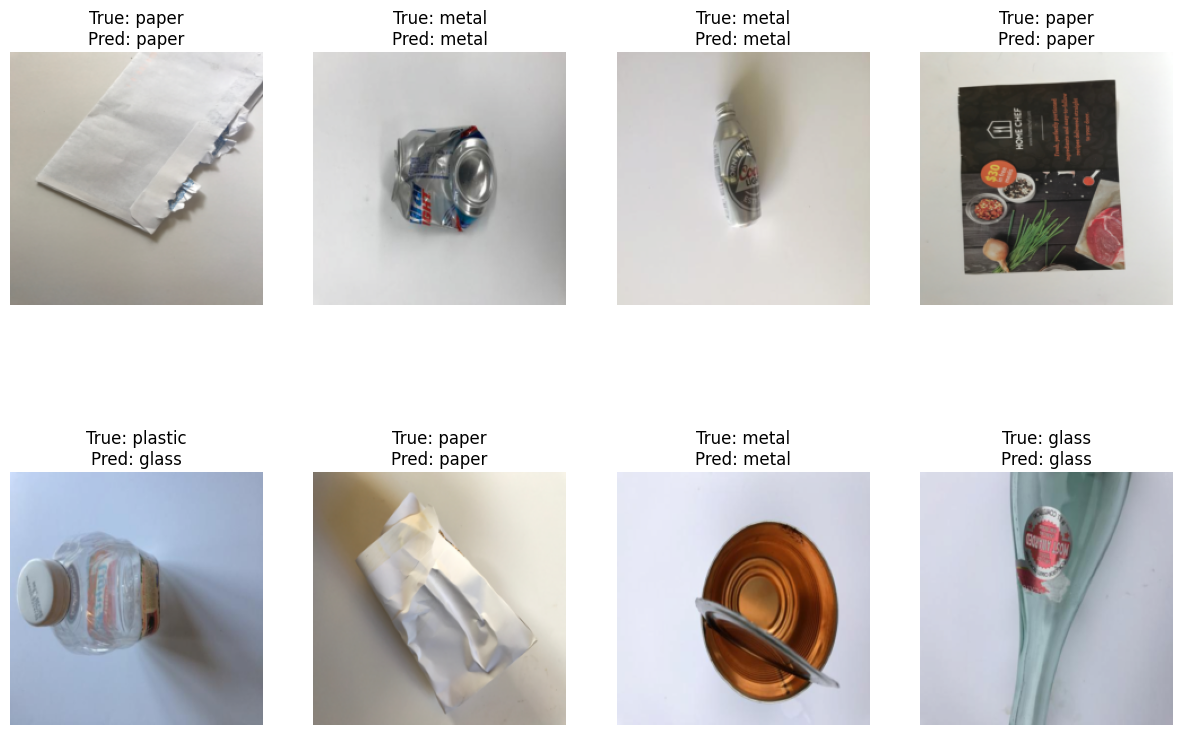

In [78]:
data_iter = iter(test_loader)
data  = next(data_iter)
visualize_predictions(model,data,device,class_names)

# Note and analysis for model improvement
1. After experiment my several architecture configuration, The model now still indicate little overfitt, so we can add more dropout or do data augmentation to increase data.
2. From Point 1, even though our model is kinda overfitt, but it still very good that give 0.72 on 500 test image.
3. With just 6M parameter i think this model has good work on this Trash classification.